In [2]:
import numpy as np
import matplotlib.pyplot as plt

First we define some model free functions which take as pool price path as input . Using these we can compute pool related quantities
from empirical data .

### Position & LP value part **(model free)**
This part computes LP's position and LP value . 

Parameters:
* ```P_a``` : LP's lower price range  boundary . 

* ```P_b``` : LP's upper price range  boundary .

* ```L``` : LP's liquidity in price range .

* ```S_p``` : current pool price .

Functions:
* ```position``` : return a tuple of amount of X and Y asset for the given pool price and LP price range .

* ```LP_value``` : return the mark-to-market value of the tokens in LP's position .

In [3]:
def position(P_a,P_b,L,S_p):
    if S_p >= P_a and S_p <= P_b :    
        X = L * (np.sqrt(S_p) - np.sqrt(P_a) )
        Y = L * (1/np.sqrt(S_p) - 1/np.sqrt(P_b))
    elif S_p > P_b :
        X = L * (np.sqrt(P_b) - np.sqrt(P_a) )
        Y = 0
    elif S_p < P_a :
        X = 0
        Y = L * (1/np.sqrt(P_a) - 1/np.sqrt(P_b))
    return X,Y
def LP_value(P_a,P_b,L,S_p , S_m):
    return position(P_a,P_b,L,S_p)[0]+ S_m*position(P_a,P_b,L,S_p)[1]

#### Plot LP's position

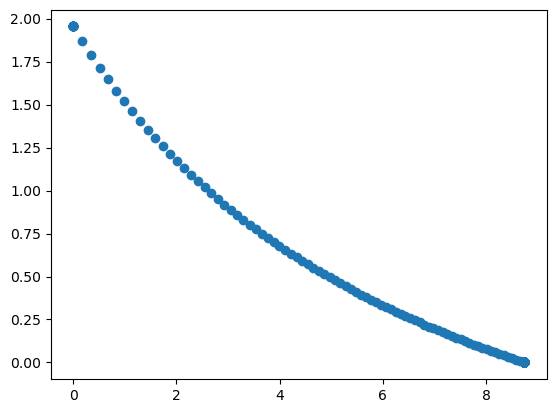

In [4]:
# An example of position curve 
X =np.array( [position(2,10,5,s/10 )[0] for s in range(1,1000)] )
Y = np.array( [position(2,10,5,s/10 )[1] for s in range(1,1000)] )
plt.scatter( X , Y )

### Fee collection part **(model free)** 
This part computes fee-related quantity for the given price paths . 

Parameters:
* ```S_p_old``` : pool price before updated .

* ```S_p_new``` : updated pool price  .

* ```S_m_new``` : updated market price .

* ```S_p_array``` : pool price path .

* ```S_m_array``` : market price path .

Functions:
* ```fee_collecting``` : return a tuple consisting of the  fee in $X$ and $Y$ earned from the given price change .

* ```fee_process``` : return an array consisting of the fee in $X$ and $Y$ earned at each moment from the given price paths  .

In [69]:
np.zeros((2,10))[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [70]:
def fee_collecting( P_a,P_b , gamma ,  L , S_p_old , S_p_new  ):

            
    return 

def fee_process(P_a,P_b , gamma ,  L , S_p_array ) :
    # time 0 ~ T
    T = len(S_p_array) - 1
    fee_X , fee_Y = np.zeros((2 , T))
    
    for i in range(T):
        A = max(S_p_array[i] , P_a)
        B = min(S_p_array[i] , P_b)
        
        # fee from X asset (pool price up)
        if S_p_array[i] < P_b and S_p_array[i+1] > A  :

            fee_X[i] = L*(1-gamma)/gamma *( np.sqrt( min( S_p_array[i+1] , P_b) ) - np.sqrt( A ))

        # fee from Y asset (pool price down)        
        elif S_p_array[i] > P_a and S_p_array[i+1] < B :
            
            fee_Y[i] = L*(1-gamma)/gamma*( 1/np.sqrt( max( S_p_array[i+1] , P_a) ) - 1/np.sqrt( B ))
            
    return fee_X , fee_Y     

### Stopping at the boundary  **(model free)**
This part we consider the stopping time to be the moment that pool price path touches (or crosses ) the predetermined boundary .

Parameters :
* ```Pl``` : lower boundary price .

* ```Pu``` : upper boundary price .

* ```S_p_collection``` : a 2d-array consists of  pool price path samples . 

* ```S_m_collection``` : a 2d-array consists of  market price path samples . 

Functions : 
* ```stop_bd_time``` : returns the time that the given pool price path touches (or crosses ) the boundary . If this doesn't happen , return the end time instead .


* ```stop_bd_sample_mean``` : returns the sample mean of LP's discounted wealth from the input price path samples .


In [ ]:
def stop_bd_time(gamma , Pl , Pu , S_p_array , p):  
    
    # time interval of the path : 0 ~ t_end
    t_end = len(S_p_array)-1
     
    for time in range(t_end+1) :

        if S_p_array[time] <= Pl or S_p_array[time] >= Pu :
            break
    
    return time

def stop_bd_sample_mean(k , gamma , Pl , Pu , S_p_collection , S_m_collection ):
    sample_number = np.shape(S_p_collection)[0]
    stop_value_array = np.array([])
    
    #run over all samples
    for i in range(sample_number):
        S_p_array = S_p_collection[i]
        S_m_array = S_m_collection[i]
        
        tau = stop_bd_time( gamma , Pl , Pu , S_p_array )
        
        #ignore the path that doesn't touch the boundary
        if tau == "not stopped yet":
            continue
        else :
            fee = disc_fee_process(r,P_a,P_b , gamma ,  L , S_p_array , S_m_array)[tau]
            
            tokens = np.exp(-r*tau)*LP_value(P_a,P_b,L, S_p_array[tau] , S_m_array[tau])
            
            stop_value_array = np.append(stop_value_array , fee + token )
            
    return np.avg(stop_value_array)

### Price dynamic **(model based)**
Here we assume the market price follows geometric random walk and uses the no-arbitrage condition
to construct pool price dynamic . 


Parameters:
* ```ln_S_m``` : logarithm of the market price .

* ```p``` : forward probability of the random walk . 

* ```delta``` : step size of the random walk .

* ```ln_S_p``` : logarithm of the pool price .

* ```ln_S_m_new``` : logarithm of the updated market price .

* ```gamma``` : fee constant in $ (0,1) $ . 

* ```T``` : end time of the generated price process .

* ```S_p_ini``` : initial pool price .

* ```S_m_ini``` : initial market price .

Functions:
* ```market_process``` : return an array of market price generated by a random walk with length $T+1$ and the given initial price .

* ```pool_update``` :  return a new log pool price by the no-arbitrage condition .

* ```pool_process``` : return an array of  pool price by the no-arbitrage condition with length $T+1$ and the given initial price  .

In [ ]:
def market_process( T , p ,delta , S_m_ini):
    S_m_array = np.zeros(T+1)
    S_m_array[0] = S_m_ini
    for time in range(1,T+1):
        U = np.random.rand()
        if U < p :
            S_m_array[time] = S_m_array[time-1]*np.exp(delta)
        else:
            S_m_array[time] = S_m_array[time-1]*np.exp(-delta)
            
    return S_m_array

def pool_process( T , p  , gamma , S_p_ini , S_m_array ):
    
    S_p_array = np.zeros(T+1)
    S_p_array[0]= S_p_ini
    
    for time in range(1,T+1):
            
        if S_m_array[time] >  S_p_array[time-1]*gamma**(-1) :

            S_p_array[time] =  S_m_array[time]*gamma

        elif S_m_array[time]  < S_p_array[time-1]*gamma:

            S_p_array[time] =  S_m_array[time]*gamma**(-1)

        else:
             S_p_array[time] =  S_p_array[time-1]
    return S_p_array 

#### Plot the price path

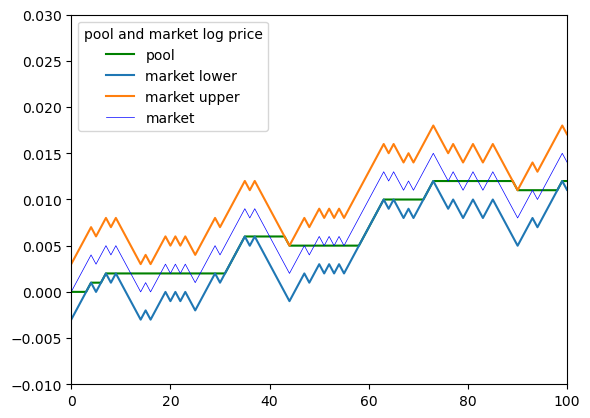

In [ ]:
delta = 10**(-3)
gamma = 0.997

# Total run time should be as large as possible
T= 1000

S_m_array = market_process( T , 0.6 , delta , 1)

S_p_array = pool_process( T , 0.6  , gamma ,1 ,S_m_array)



T_array=np.arange(T+1)

plt.figure()
plt.plot(T_array, np.log(S_p_array) ,'g' , label='pool')
plt.plot(T_array, np.log(gamma*S_m_array) , label='market lower')
plt.plot(T_array, np.log(S_m_array*(gamma**-1))  , label='market upper' )
plt.plot(T_array, np.log(S_m_array) , 'b',linewidth=0.5 , label='market')
plt.legend(title="pool and market log price")

plt.xlim(0,100)
plt.ylim(-0.01,0.03)
plt.show()

### Expected wealth stopped at boundary **(model based)**
This part uses Monte-Carol  to generate path samples and compute expected wealth stopped at boundary  .

Functions:
* ```exp_wealth_bd``` : returns the  expected wealth  starting from given initial price and stopped at the boundary . 

In [ ]:
def exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , ln_Sp_ini , ln_Sm_ini , L ,gamma , r , p):
    delta = -np.log(gamma)/k 
    P_a, P_b , S_p_ini , S_m_ini = np.exp( np.array([ln_Pa, ln_Pb ,ln_Sp_ini , ln_Sm_ini])*delta )
    data = np.zeros(10**5)
    
    for i in range(10**5):
        Sp_array , Sm_array  = pool_process( T , p  , delta , gamma , S_p_ini , S_m_ini )
        data[i] = disc_wealth_stopped(r ,P_a,P_b , gamma ,  Tau ,  L , S_p_array , S_m_array)
    return np.average(data)

In [ ]:
exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , ln_Pu  , ln_Pu+k , L ,gamma , 0 , p)

The following is to compare with the result from Bellman equation

In [191]:
#compute the expected wealth at all left and right endpoints to compare with the result from Bellman equation
def exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma , r , p):
    N = ln_Pu - ln_Pl - 1
    V_0 = np.zeros(2*N+2)
    for n in range(2*N+2):
        print("index " , n)
        if n <= N :
            V_0[n] = exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , n+ln_Pl , n+ln_Pl-k , L ,gamma , r , p)
        elif n >= N+1 :
            V_0[n] = exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , n+ln_Pl-N , n-N+ln_Pl+k , L ,gamma , r , p)
    return V_0


index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16
index  17
index  18
index  19
index  20
index  21
index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16
index  17
index  18
index  19
index  20
index  21
index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16
index  17
index  18
index  19
index  20
index  21
index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16
index  17
index  18
index  19
index  20
index  21
index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16


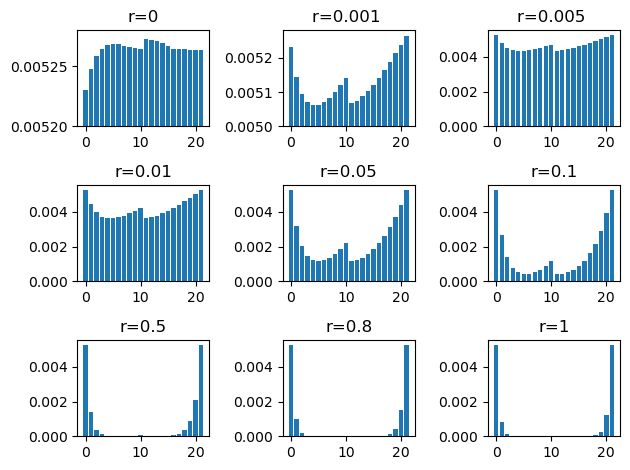

In [194]:
#result with different interest rate
N = ln_Pu - ln_Pl - 1
fig , ax =plt.subplots(3,3)
V_0 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma , 0 , p)
V_1 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.001 , p)
V_2 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.005 , p)
V_3 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.01 , p)
V_4 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.05 , p)
V_5 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.1 , p)
V_6 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.5 , p)
V_7 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.8 , p)
V_8 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  1 , p)


N = ln_Pu - ln_Pl -1

ax[0,0].bar(np.arange(2*N+2), V_0  )
ax[0,0].set_title( "r=0")
ax[0,0].set_ylim(5.2*10**(-3),5.28*10**(-3))

ax[0,1].bar(np.arange(2*N+2),V_1  )
ax[0,1].set_title( "r=0.001 ")
ax[0,1].set_ylim(5*10**(-3),5.28*10**(-3))

ax[0,2].bar(np.arange(2*N+2),V_2  )
ax[0,2].set_title( "r=0.005 ")

ax[1,0].bar(np.arange(2*N+2),V_3 )
ax[1,0].set_title( "r=0.01")

ax[1,1].bar(np.arange(2*N+2),V_4 )
ax[1,1].set_title( "r=0.05")

ax[1,2].bar(np.arange(2*N+2),V_5 )
ax[1,2].set_title( "r=0.1")

ax[2,0].bar(np.arange(2*N+2),V_6 )
ax[2,0].set_title( "r=0.5")

ax[2,1].bar(np.arange(2*N+2),V_7 )
ax[2,1].set_title( "r=0.8")

ax[2,2].bar(np.arange(2*N+2),V_8 )
ax[2,2].set_title( "r=1")
plt.tight_layout()

### Cost normalization

In [198]:
V0 = exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , 0 , 0 , L ,gamma , r , p)
delta = -np.log(gamma)/k
P_a , P_b = np.exp(  np.array([ln_Pa, ln_Pb])*delta )
V0_normalized = V0 /position_value(P_a,P_b,L, 1, 1)

In [199]:
V0_normalized

1.002865528692053

In [197]:
gamma = 0.997
k=100         
delta = -np.log(gamma)/k 
#position range
ln_Pa = -5  
ln_Pb =  5 
L = 1
r=0.1
p=0.5

0.0014829499678218592

### Loss versus rebalancing (LVR)
In the following we introduce a rebalancing strategy $\{(X^R_n , Y^R_n)\}_{n \geq 0}$ that outperforms the LP's asset value : 
At the begin , the initial position is $(X^R_0 , Y^R_0) \equiv (X_0 , Y_0)$ (same as LP's initial
position) . Then we require the process   satisfying for all $n\geq 0$  :

1. risky asset replication : $Y^R_n = Y_n$
2. self-financing : $ e^{-(n+1)r} V_{n+1} - e^{-nr} V_n = e^{-(n+1)r} S_{n+1} Y^R_n - e^{-nr} S_{n} Y^R_n \quad$  where $V_n \equiv X^R_{n} + S_n Y^R_{n}$ is the portfolio value of the strategy .

In other words , this strategy maintains the same amount of risky asset $Y$ as LP by trading with the market and
it must be self-financing (in the discounted sense). Note that 
$$
\begin{align*}
e^{-n r}V_n &= V_0 + \sum^n_{m=1} Y_{m-1} (  e^{-mr }S_m - e^{-(m-1)r}S_{m-1}) \\
\Rightarrow 
X^R_n &= e^{n r } \big\{ V_0 + \sum^n_{m=1} Y_{m-1} (  e^{-mr }S_m - e^{-(m-1)r}S_{m-1}) \big\} - S_n Y_n  
\end{align*}
$$

It's not diffcult to show that the rebalancing strategy outperforms , i.e $ V_n \geq  W_n \equiv X_n + S_n Y_n $ , which implies $X^R_n \geq X_n \geq 0 $ . So it's indeed an admissible strategy .  

Functions:
* ```position_R``` : return a tuple-array consists of the rebalancing position w.r.t the input pool price and market price paths .  

In [131]:
def position_R(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array):
    length = len(S_p_array)
    X_R = np.zeros(length)
    
    X_R[0] = position(P_a,P_b,L,S_p_array[0])[0]
    
    # Y_R equals to the amount of Y in LP's position
    Y_R = np.array( [position(P_a,P_b,L,S_p_array[time])[1] for time in range(length)] )
    V_0 = X_R[0] + S_p_array[0]*Y_R[0]
    sum = 0
    for time in range(1,length):
        sum+= Y_R[time-1]*(np.exp(-time*r)*S_m_array[time] - np.exp(-(time-1)*r)*S_m_array[time-1])
        X_R[time] = np.exp(time*r)*( V_0 + sum ) - S_m_array[time] * Y_R[time]
    return X_R , Y_R

def position_R_value(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array):
    X_R = position_R(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array)[0]
    Y_R = position_R(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array)[1]
    
    return  X_R + S_m_array*Y_R

We can plot the result to compare $V_n$ and $W_n$ ($r=0$ case) for different value of $p$

In [180]:
gamma = 0.997
k=10
delta = -np.log(gamma)/k
T = 10**5
r=0
P_a = np.exp(-5*delta)
P_b = np.exp(5*delta)
p = [0.4 , 0.5 , 0.6]
V = np.empty( 3 , dtype =object)
W = np.empty( 3 , dtype =object)

for i in range(3):
    S_p_array , S_m_array = pool_process( T , p[i]  , delta , gamma )
    X_R ,Y_R= position_R(r , P_a , P_b , gamma ,  1 , S_p_array , S_m_array)
    V[i] = position_R_value(r ,P_a,P_b , gamma ,  1 , S_p_array , S_m_array)
    W[i] = np.array([asset_value(P_a,P_b,1,S_p_array[time] , S_m_array[time] ) for time in range(T+1)  ])
    

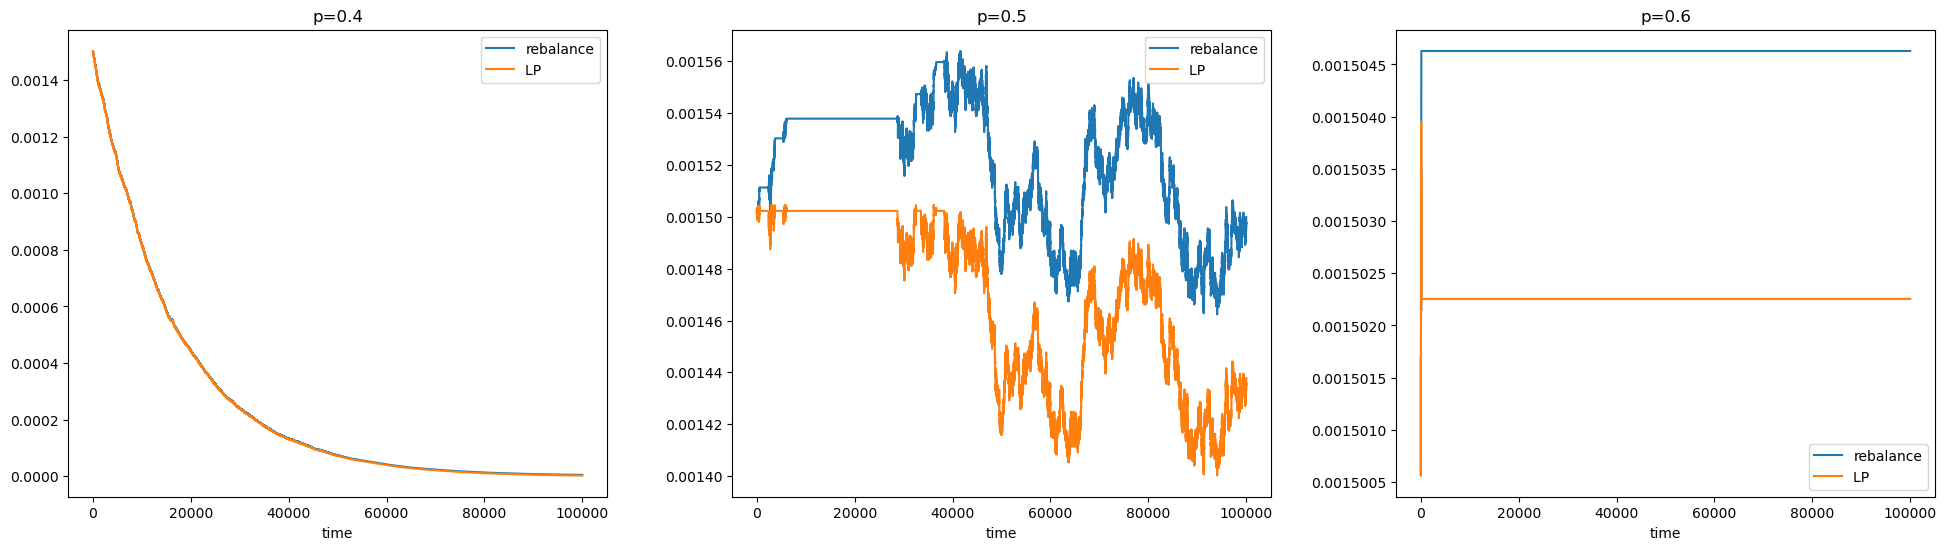

In [181]:
fig , ax = plt.subplots(1,3 , figsize =(20,6))
for i in range(3):
    ax[i].plot(V[i] , label = "rebalance")
    ax[i].plot(W[i] , label = "LP ")
    ax[i].legend()
    ax[i].set_xlabel("time")
    ax[i].set_title("p="+str(p[i]))
plt.tight_layout(pad=2.5)    

For $p=0.4$ case , the curves almost overlap . Define the **Loss versus rebalancing** to be the difference $LVR_n \equiv V_n - W_n = X^R_n - X_n$ and we plot it in the following:  

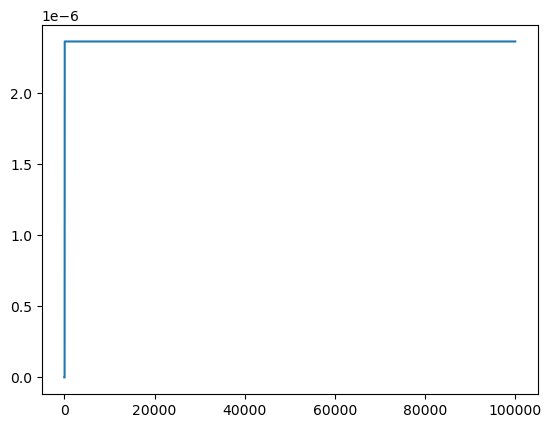

In [182]:
plt.plot(V[0]-W[0])

Now we can try to use this rebalancing portfolio as bechmark to evaluate the LP'position (fee plus asset value) . 

If the fee part can cover this oppurtinuity cost , then the LP's position is worthy , otherwise it's not a good investment .

In [183]:
def LVR(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array):
    length = len(S_p_array)
    X_R ,Y_R= position_R(r , P_a , P_b , gamma ,  L , S_p_array , S_m_array)
    W = np.array([asset_value(P_a,P_b, L ,S_p_array[time] , S_m_array[time] ) for time in range(length)  ])
    V = position_R_value(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array)
    return V-W

Incorporate this idea into our problem :

$$
V(S^* , M) = 
\mathbb{E}_{( S^* , M) }\big[ 
\sum_{n=0}^{T-1} e^{-rn} [f_X(S^*_{n+1} , S^*_n) + S^*_{n+1}  e^{ M_{n+1}} f_Y( S^*_{n+1} , S^*_n)  ] + e^{-rT} W_T \big]
- \mathbb{E}_{( S^* , M) }\big[  e^{-rT} V_T \big]
$$